In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pre procesamiento + Utilidades

## Importar librerías

In [1]:
import math
import matplotlib.gridspec as gridspec
import matplotlib.pylab as plt 
import numpy as np
import pandas as pd

from scipy.signal import butter, lfilter, find_peaks
from sklearn import decomposition
import matplotlib.pyplot as plt

In [2]:
!pip install mne
import mne

## Variables

In [3]:
path = "/content/drive/MyDrive/procesados"

In [4]:
srate = 128

In [5]:
seed = 5233

In [6]:
sujetos = [8, 9, 10, 12, 13]
estados = [1,2]

## Funciones útiles


### Filtros

In [7]:
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [8]:
# Sample rate and desired cutoff frequencies (in Hz).
def apply_filter(EEGdata):
  lowcut = 2
  highcut = 20
  order = 6
  EEGdata_filt = np.zeros_like(EEGdata)
  for i,temp_canal in enumerate(EEGdata):
    EEGdata_filt[i,:] = butter_bandpass_filter(temp_canal, lowcut, highcut, srate, order)

  return EEGdata_filt

### GFP

In [9]:
#%% Calculo GFP

def calculo_gfp(data,srate,do_plot):
    # gfp as standar deviation of each instant medition
    gfp = np.std(data, axis=0)
    # local maxima  => locmax
    gfp_peaks = locmax(gfp)
    # gcp_value in peaks
    gfp_values = gfp[gfp_peaks]
    # normalizing constant in GEV
    gfp2 = np.sum(gfp_values**2) 

    n_gfp = gfp_peaks.shape[0]
    if do_plot=='yes':
        marcasx = np.arange(3)*srate
        xlab    = ['0','1','2']
        plt.gcf().set_size_inches(30, 6)
        plt.plot(np.arange(len(gfp)),gfp,c='k')
        plt.scatter(gfp_peaks,gfp_values,c='r')
        plt.xlim(0,srate*3)
        plt.xticks(marcasx,xlab)
        plt.xlabel('Tiempo (s)')
        plt.ylabel('GFP')
        plt.show()
    return gfp,gfp_peaks,gfp_values,gfp2,n_gfp

In [10]:
def locmax(x):
    dx = np.diff(x) # discrete 1st derivative
    zc = np.diff(np.sign(dx)) # zero-crossings of dx
    m = 1 + np.where(zc == -2)[0] # indices of local max.
    return m

### KMeans modificado

In [11]:
# k means modificado
def kmeans3(gfp_maps,gfp_eval, n_maps, n_runs=10, maxerr=1e-6, maxiter=500):
  # los inputs son los mapas, el valor del gfp en los picos,
  # la cantidad de clusters, la cantidad de corridas,
  # error máximo, número máximo de iteraciones
  V = gfp_maps.T
  n_gfp = V.shape[0]
  n_ch = V.shape[1]
  sumV2 = np.sum(V**2)

  # Guarda resultados de cada corrida
  cv_list =   []  # cross-validation criterion for each k-means run
  maps_list = []  # microstate maps for each k-means run
  L_list =    []  # microstate label sequence for each k-means run
  
  gev_list =  []  # GEV of each map for each k-means run
  gevT_list = []  # total GEV values for each k-means run

  gfp2 = np.sum(gfp_eval**2)

  for run in range(n_runs):
    # initialize random cluster centroids 
    rndi = np.random.permutation(n_gfp)[:n_maps]
    maps = V[rndi, :]
    # normalize row-wise (across EEG channels)
    maps /= np.sqrt(np.sum(maps**2, axis=1, keepdims=True))
    # initialize
    n_iter = 0
    var0 = 1.0
    var1 = 0.0
    # convergence criterion: variance estimate (step 6)
    while ( (np.abs((var0-var1)/var0) > maxerr) & (n_iter < maxiter) ):
      # (step 3) microstate sequence (= current cluster assignment)
      C = np.dot(V, maps.T)
      C /= (n_ch*np.outer(gfp_eval, np.std(maps, axis=1)))
      L = np.argmax(C**2, axis=1)
      # (step 4)

      gev = np.zeros(n_maps)  ## new

      for k in range(n_maps):
        Vt = V[L==k, :]
        # (step 4a)
        Sk = np.dot(Vt.T, Vt)
        # (step 4b)
        evals, evecs = np.linalg.eig(Sk)
        v = evecs[:, np.argmax(np.abs(evals))]
        v = v.real
        maps[k, :] = v/np.sqrt(np.sum(v**2))
        # (step 5)
        var1 = var0
        var0 = sumV2 - np.sum(np.sum(maps[L, :]*V, axis=1)**2)
        var0 /= (n_gfp*(n_ch-1))
        n_iter += 1
        if (n_iter > maxiter):
          print((f"\tK-means run {run+1:d}/{n_runs:d} did NOT converge "
                   f"after {maxiter:d} iterations."))
          
        # GEV (global explained variance) of cluster k
        r = L==k  ## new
        gev[k] = np.sum(gfp_eval[r]**2 * C[r,k]**2)/gfp2  ## new

      # CROSS-VALIDATION criterion for this run (step 8)

    gev_total = np.sum(gev)     ## new
    gev_list.append(gev)        ## new
    gevT_list.append(gev_total) ## new

    cv = var0 * (n_ch-1)**2/(n_ch-n_maps-1.)**2
    cv_list = np.append(cv_list,cv)
    maps_list.append(maps)
    L_list.append(L)

  # select best run. Lo elige en función del validación cruzada
  k_opt = np.argmin(cv_list)
  maps = maps_list[k_opt]
  L  = L_list[k_opt]
  cv = cv_list[k_opt]
  gev = gev_list[k_opt]

  return maps, L, cv, gev

### Silhoutte

In [12]:
def silhoutte_modificado2(maps,data,labels,ch,n_clusters):
    if data.shape[0]!=ch:
       data=data.T
    elif maps.shape[0]!=ch:
       maps=maps.T
    
    corr_ctodos =np.abs(np.corrcoef(data.T))
    sil = []
    for n,i in enumerate(data.T):
        L = labels[n]
        dist = 1-corr_ctodos[n,:]
        dist_=np.delete(dist,n)
        lab_ = np.delete(labels,n)
        prom_dist=[]
        for k in range(n_clusters):
            prom_dist.append(np.mean(dist_[lab_==k]))
        a=prom_dist[L]
        b=np.min(np.delete(prom_dist,L))
        sil.append((b-a)/np.max([a,b]))
    return sil

In [13]:
#%% Grafico silhoutte
def grafica_sil(n_clusters,sil,labels):
    import matplotlib.cm as cm
    # Create a subplot with 1 row and 2 columns
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 1, 1)
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.5, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(labels) + (n_clusters + 1) * 10])

    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = np.mean(sil)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = np.array(sil)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
   # ax1.set_xticks([-1,-0.5,-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()

## Definición de Canales

In [14]:
# Preparación para posteriores gráficos de la cabeza
# Montage 10-20
mont1020 = mne.channels.make_standard_montage('standard_1020')
# Elijo canales que tengo
kept_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 
                 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'FC1', 'FC2',
                 'FC5', 'FC6','CP1','CP2','CP5','CP6','AFz','Fpz','POz']

ind = [i for (i, channel) in enumerate(mont1020.ch_names) if channel in kept_channels]
mont1020_30 = mont1020.copy()
# Me quedo solo con los canales seleccionados
mont1020_30.ch_names = [mont1020.ch_names[x] for x in ind]
kept_channel_info = [mont1020.dig[x+3] for x in ind]
# Me quedo con las referencias desde dónde están ubicados los canales
mont1020_30.dig = mont1020.dig[0:3]+kept_channel_info
info_eeg = mne.create_info(ch_names=mont1020_30.ch_names, sfreq=srate,
                            ch_types='eeg').set_montage(mont1020_30)

# Tarea 1: Inspección de los mapas topográficos para los máximos de GFP 

## Leemos los archivos y creamos dataset

In [15]:
data = []
all_medition = []
for sujeto in sujetos:
  for act in estados:
    filename = f'{path}/suj_{sujeto}_bl_{act}.txt'

    datos   = pd.read_csv(filename, sep=',', header=None)
    EEGdata = apply_filter(datos.to_numpy())

    if len(all_medition) > 1:
      all_medition = np.concatenate((all_medition, EEGdata), axis=1)
    else:
      all_medition = EEGdata

## Calculamos GFP

In [16]:
gfp,gfp_peaks,gfp_values,gfp2,n_gfp=calculo_gfp(all_medition,srate,'no')

## Mapas de GFP (pgfp)

In [17]:
p_gfp = all_medition[:, gfp_peaks]

## PCA - TODO (hay que hacer PCA?)

peaks count: 13110
pca shape: (30, 5)


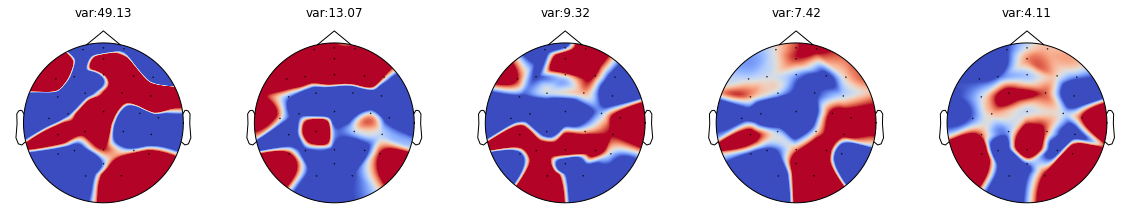

In [18]:
print(f"peaks count: { len(gfp_peaks) }")
# TODO
pca = decomposition.PCA(n_components=5)
# pca = decomposition.PCA()
pca.fit(p_gfp)
pcs = pca.transform(p_gfp)
print(f"pca shape: { pcs.shape }")

var = pca.explained_variance_ratio_
fig2, ax = plt.subplots(ncols=pcs.shape[1], figsize=(20, 6), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)
for p in range(pcs.shape[1]):
  mne.viz.plot_topomap(pcs[:,p],
                    info_eeg,
                    cmap='coolwarm', vmin=-100,vmax=100, contours=0,
                    axes=ax[p],show=False)
  ax[p].set_title('var:'+str(round(var[p]*100,2)) )

# Tarea 2: Calculo de microestados utilizando k-means modificados 

## Calculamos el k óptimo

In [19]:
## GEV
## https://github.com/Frederic-vW/eeg_microstates/blob/master/eeg_microstates3.py#L634
## https://github.com/Frederic-vW/eeg_microstates/blob/master/eeg_microstates3.py#L720
## https://www.frontiersin.org/articles/10.3389/fncom.2018.00070/full

In [103]:
X = p_gfp

n_max = 0
cv_max = 999999999
maps_kmeans_max = None
labels_gfp_max = None
cvs = []
data_silhouette = []
gev_list = []
for n_clusters in range(2,11):
  print("Cluster: {k}".format(k=n_clusters))
  maps_kmeans,labels_gfp,cv, gev = kmeans3(X, gfp_values, n_clusters, n_runs=100, maxerr=1e-6, maxiter=500)
  
  cvs.append((n_clusters, cv))
  data_silhouette.append((n_clusters, maps_kmeans, labels_gfp))
  gev_list.append((n_clusters, gev))
  
  if cv < cv_max:
    n_max = n_clusters
    cv_max = cv
    maps_kmeans_max = maps_kmeans
    labels_gfp_max = labels_gfp

Cluster: 2
Cluster: 3
Cluster: 4
Cluster: 5
Cluster: 6
Cluster: 7
	K-means run 50/100 did NOT converge after 500 iterations.
	K-means run 50/100 did NOT converge after 500 iterations.
	K-means run 50/100 did NOT converge after 500 iterations.
	K-means run 50/100 did NOT converge after 500 iterations.
Cluster: 8
	K-means run 10/100 did NOT converge after 500 iterations.
	K-means run 10/100 did NOT converge after 500 iterations.
	K-means run 10/100 did NOT converge after 500 iterations.
	K-means run 10/100 did NOT converge after 500 iterations.
	K-means run 16/100 did NOT converge after 500 iterations.
	K-means run 16/100 did NOT converge after 500 iterations.
	K-means run 16/100 did NOT converge after 500 iterations.
	K-means run 16/100 did NOT converge after 500 iterations.
	K-means run 18/100 did NOT converge after 500 iterations.
	K-means run 18/100 did NOT converge after 500 iterations.
	K-means run 18/100 did NOT converge after 500 iterations.
	K-means run 18/100 did NOT converge a

## Gráfica de Microestados para el k óptimo

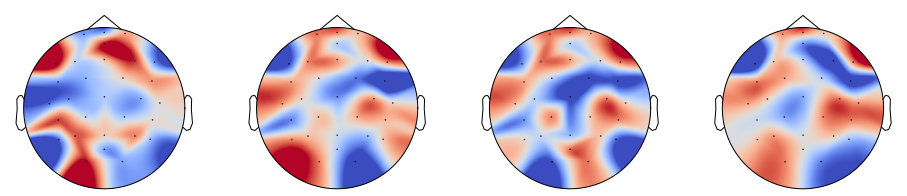

In [104]:
n_clusters = n_max
cv = cv_max
maps_kmeans = maps_kmeans_max
labels_gfp = labels_gfp_max 

fig3, ax = plt.subplots(ncols=n_clusters, figsize=(4*n_clusters, 6), gridspec_kw=dict(top=0.9),
                      sharex=True, sharey=True)
for n in range(n_clusters):
    mne.viz.plot_topomap(maps_kmeans[n,:].T,info_eeg,
                        vmin=-0.3,vmax=0.3, cmap='coolwarm',
                        contours=0, axes=ax[n],show=False)

## Silhouette para cada K - TODO: graficar (o hacer tabla)

In [105]:
sil_prom_k = []
for data_s in data_silhouette:
  n_clust = data_s[0]
  sil = silhoutte_modificado2(data_s[1], X,data_s[2], 30, n_clust)
  sil_prom_k.append((n_clust, np.mean(sil)))

In [106]:
sil_prom_k

[(2, 0.18324167280220705),
 (3, 0.17278118979693935),
 (4, 0.22032230475569095),
 (5, 0.19324631207662377),
 (6, 0.18956273503709542),
 (7, 0.18236861058153397),
 (8, 0.1567123101656778),
 (9, 0.1605823595367482),
 (10, 0.14891236421126466)]

In [107]:
sil_k = []
sil_vals = []

for s in sil_prom_k:
  sil_k.append(s[0])
  sil_vals.append(s[1])

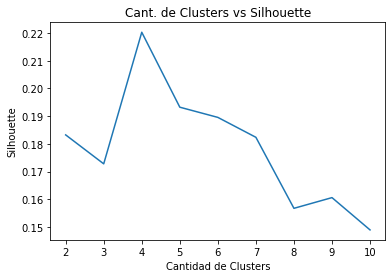

In [108]:
plt.plot(sil_k,sil_vals)
plt.title('Cant. de Clusters vs Silhouette')
plt.xlabel('Cantidad de Clusters')
plt.ylabel('Silhouette')
plt.show()

## Obtenemos CV para cada K

In [115]:
cvs

[(2, 23.66972769543886),
 (3, 22.310863329043425),
 (4, 21.789075599886438),
 (5, 21.92641086709674),
 (6, 22.678237228074526),
 (7, 23.55651175386123),
 (8, 24.97316708651892),
 (9, 26.692457728229556),
 (10, 28.71403360639337)]

In [116]:
cv_k = []
cv_values = []

for cv_data in cvs:
  cv_k.append(cv_data[0])
  cv_values.append(cv_data[1])

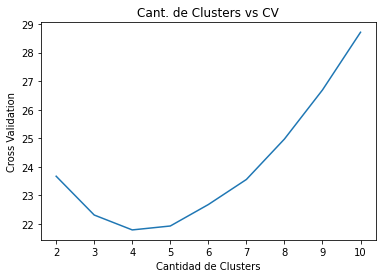

In [117]:
plt.plot(cv_k,cv_values)
plt.title('Cant. de Clusters vs CV')
plt.xlabel('Cantidad de Clusters')
plt.ylabel('Cross Validation')
plt.show()

## Calculamos GEV para cada K

In [109]:
gev_list
# Debemos sumar los GEV de cada K
# Source: https://www.frontiersin.org/articles/10.3389/fncom.2018.00070/full (párrafo anterior a sección "2.2.1. Number of Clusters")
gev_list_proc = [(i[0], sum(i[1])) for i in gev_list]
gev_list_proc

[(2, 0.5735259377231673),
 (3, 0.6272349558979331),
 (4, 0.6634180167577888),
 (5, 0.6878503517398925),
 (6, 0.7034909683110745),
 (7, 0.7182079098231566),
 (8, 0.7277920256971465),
 (9, 0.7361064131031438),
 (10, 0.7437929495519906)]

In [110]:
gev_k = []
gev_value = []
for gev in gev_list_proc:
  gev_k.append(gev[0])
  gev_value.append(gev[1])

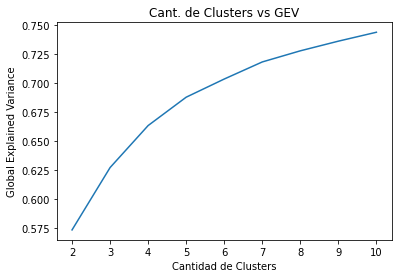

In [111]:
plt.plot(gev_k,gev_value)
plt.title('Cant. de Clusters vs GEV')
plt.xlabel('Cantidad de Clusters')
plt.ylabel('Global Explained Variance')
plt.show()

## Mostramos el K óptimo junto con su valor de CV (Validación Cruzada)

In [112]:
print(n_clusters)
print(cv)

4
21.789075599886438


## Mostramos el Silhouette del K óptimo

For n_clusters = 4 The average silhouette_score is : 0.22032230475569095


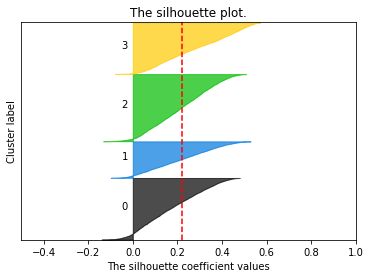

In [113]:
sil = silhoutte_modificado2(maps_kmeans, p_gfp,labels_gfp, 30,n_clusters)
grafica_sil(n_clusters,sil,labels_gfp)

## Mostramos la Varianza Global Explicada para el K óptimo (TODO: SACAR)

In [34]:
print(f"peaks count: { len(gfp_peaks) }")
X = all_medition[:,gfp_peaks]

# pca = decomposition.PCA(n_components=5)
pca = decomposition.PCA()
pca.fit(X)
pcs = pca.transform(X)
print(f"pca shape: { pcs.shape }")

peaks count: 13110
pca shape: (30, 30)


In [35]:
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features

array([49.1, 62.2, 71.5, 78.9, 83. , 86.1, 88.3, 90.1, 91.4, 92.3, 93.2,
       93.9, 94.6, 95.2, 95.7, 96.2, 96.6, 97. , 97.4, 97.8, 98.1, 98.4,
       98.7, 99. , 99.2, 99.4, 99.6, 99.7, 99.8, 99.8])

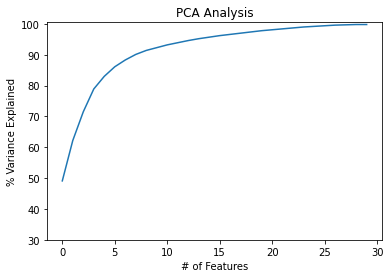

In [36]:
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')


plt.plot(var)

# Tarea 3: Validación externa de los microestados 

## Nuevas Dependencias

In [37]:
!pip install scikit-learn-extra

In [38]:
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_samples, silhouette_score, rand_score, adjusted_rand_score
from sklearn.metrics.cluster import pair_confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## Nuevas funciones

In [39]:
def calcula_sse_kmedoids(KM,d):
  se = []
  for i in range(0,KM.n_clusters):
    se.append(sum(d[KM.medoid_indices_[i],KM.labels_==i]**2))
  return sum(se)

In [40]:
def PAM(data, true_labels, clusters = 4, metric = 'minkowski', method = 'pam', init = 'k-medoids++', random_state = 1234):
  KM_meta = KMedoids(n_clusters=clusters, metric=metric, method=method, init=init, random_state=random_state).fit(data)

  rand = rand_score(true_labels, KM_meta.labels_)
  ari = adjusted_rand_score(true_labels, KM_meta.labels_)
  conf_matrix = pair_confusion_matrix(true_labels, KM_meta.labels_)

  return KM_meta, rand, ari, conf_matrix

In [41]:
def KMeans_Custom(data, clusters = 4):
  return KMeans(n_clusters=clusters).fit(data)

## PAM

### Métrica = Minkowski

In [42]:
# see: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html
clusters = 4
metric='minkowski'
method='pam'
pam_mink, rand_mink, ari_mink, conf_matrix_mink = PAM(p_gfp.T, labels_gfp, clusters=clusters, metric=metric, method=method, random_state=seed)

In [43]:
print(rand_mink)
print(ari_mink)
print(conf_matrix_mink)

0.6210877301210719
0.10691417656023514
[[87507620 39421014]
 [25698466 19231890]]


### Métrica = Correlación de Pearson

In [44]:
clusters = 4
metric='correlation' # Pearson
method='pam'
pam_corr, rand_corr, ari_corr, conf_matrix_corr = PAM(p_gfp.T, labels_gfp, clusters=clusters, metric=metric, method=method, random_state=seed)

In [45]:
print(rand_corr)
print(ari_corr)
print(conf_matrix_corr)

0.6447312997708179
0.11324293165207278
[[93795914 33132720]
 [27923400 17006956]]


### Métrica = Euclídea

In [46]:
clusters = 4
metric='euclidean'
method='pam'
pam_eucl, rand_eucl, ari_eucl, conf_matrix_eucl = PAM(p_gfp.T, labels_gfp, clusters=clusters, metric=metric, method=method, random_state=seed)

In [47]:
print(rand_eucl)
print(ari_eucl)
print(conf_matrix_eucl)

0.6210877301210719
0.10691417656023514
[[87507620 39421014]
 [25698466 19231890]]


### Métrica = Canberra

In [48]:
clusters = 4
metric='canberra'
method='pam'
pam_canb, rand_canb, ari_canb, conf_matrix_canb = PAM(p_gfp.T, labels_gfp, clusters=clusters, metric=metric, method=method, random_state=seed)

In [49]:
print(rand_canb)
print(ari_canb)
print(conf_matrix_canb)

0.643924638449231
0.09327757597526681
[[95155158 31773476]
 [29421276 15509080]]


## KMeans

In [50]:
clusters = 4
kmean = KMeans_Custom(p_gfp.T, clusters)

In [51]:
true_labels = labels_gfp

rand_kmean = rand_score(true_labels, kmean.labels_)
ari_kmean = adjusted_rand_score(true_labels, kmean.labels_)
conf_matrix_kmean = pair_confusion_matrix(true_labels, kmean.labels_)

In [52]:
print(rand_kmean)
print(ari_kmean)
print(conf_matrix_kmean)

0.6209573441575561
0.10318359914169502
[[87788086 39140548]
 [26001340 18929016]]


# Tarea 4: Visualización 

## Imports y Utilidades

In [73]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [88]:
def graficar_PCA(model, raw_data, n_components = 2, xlabel = "Componente nro. 1", ylabel = "Componente nro. 2", random_state = 1234, plot = "yes"):
  pca = PCA(n_components=n_components, random_state=random_state)

  pca.fit(raw_data)
  x_pca = pca.transform(raw_data)

  centroides_pca = pca.transform(model.cluster_centers_)

  if plot == "yes":
    plt.figure(1, figsize=(8, 6))
    plt.clf()
    #plt.scatter(x[:, 0], x[:, 1], color='k', alpha=.25, edgecolor='k')
    plt.scatter(x_pca[:, 0], x_pca[:, 1], 
                c=model.labels_, alpha=.25, edgecolor='k')
    plt.scatter(centroides_pca[:, 0], centroides_pca[:, 1], 
                s=200, marker = '*', c='k', edgecolor=None)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(())
    plt.yticks(())

In [97]:
## https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
def TSNE_Custom(model_data, model_centroids, model_labels, n_components=2, learning_rate='auto', init='random', random_state=1234, plot='no'):
  tsne = TSNE(n_components=n_components, learning_rate=learning_rate, init=init, random_state=random_state)

  tsne.fit(model_data)

  x_tsne = tsne.fit_transform(model_data)

  centroides_tsne = tsne.fit_transform(model_centroids)

  if plot!='no':
    plt.figure(1, figsize=(8, 6))
    plt.clf()
    #plt.scatter(x[:, 0], x[:, 1], color='k', alpha=.25, edgecolor='k')
    plt.scatter(x_tsne[:, 0], x_tsne[:, 1], 
                c=model_labels, alpha=.25, edgecolor='k')
    plt.scatter(centroides_tsne[:, 0], centroides_tsne[:, 1], 
                s=200, marker = '*', c='k', edgecolor=None)
    plt.xlabel('Componente nro. 1')
    plt.ylabel('Componente nro. 2')
    plt.xticks(())
    plt.yticks(())


## PAM - distancia Minkowski

### PCA

[685.08947525 182.37821028]
[0.49117534 0.13075617]


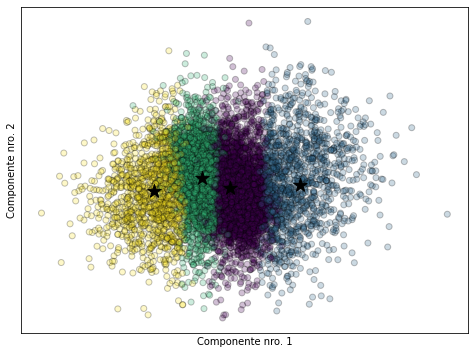

In [55]:
graficar_PCA(model=pam_mink, raw_data=p_gfp.T, random_state=seed)

### TSNE

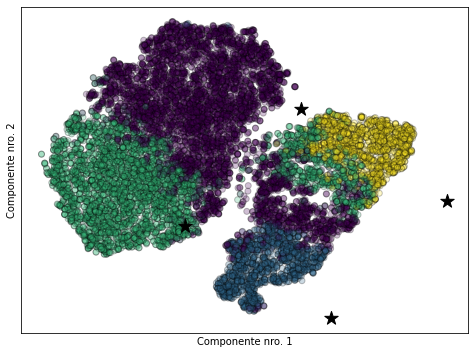

In [101]:
TSNE_Custom(model_data=p_gfp.T, model_centroids=pam_mink.cluster_centers_, model_labels=pam_mink.labels_, random_state=seed, plot='yes')

## PAM - distancia Corr Pearson

### PCA

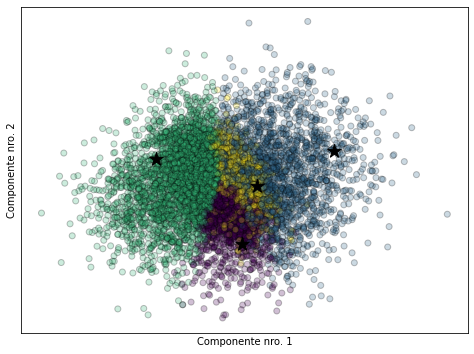

In [102]:
graficar_PCA(model=pam_corr, raw_data=p_gfp.T, random_state=seed)

### TSNE

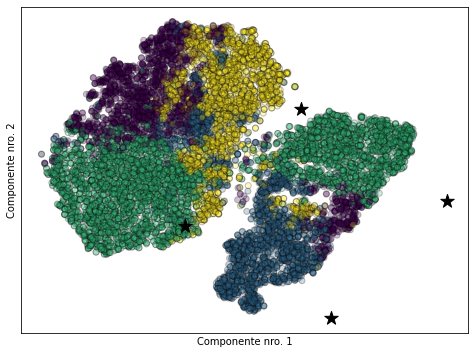

In [71]:
TSNE_Custom(model_data=p_gfp.T, model_centroids=pam_corr.cluster_centers_, model_labels=pam_corr.labels_, random_state=seed, plot='yes')

## PAM - distancia Euclídea

### PCA

[685.08947525 182.37821028]
[0.49117534 0.13075617]


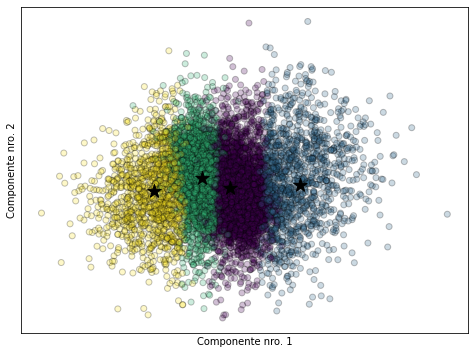

In [57]:
graficar_PCA(model=pam_eucl, raw_data=p_gfp.T, random_state=seed)

### TSNE

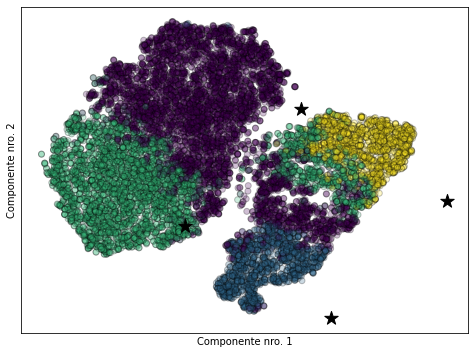

In [100]:
TSNE_Custom(model_data=p_gfp.T, model_centroids=pam_eucl.cluster_centers_, model_labels=pam_eucl.labels_, random_state=seed, plot='yes')

## PAM - distancia Canberra

### PCA

In [58]:
graficar_PCA(model=pam_canb, raw_data=p_gfp.T, random_state=seed)

[685.08947525 182.37821028]
[0.49117534 0.13075617]


### TSNE

In [70]:
TSNE_Custom(model_data=p_gfp.T, model_centroids=pam_canb.cluster_centers_, model_labels=pam_canb.labels_, random_state=seed, plot='yes')

## Kmeans

### PCA

[685.08947525 182.37821028]
[0.49117534 0.13075617]


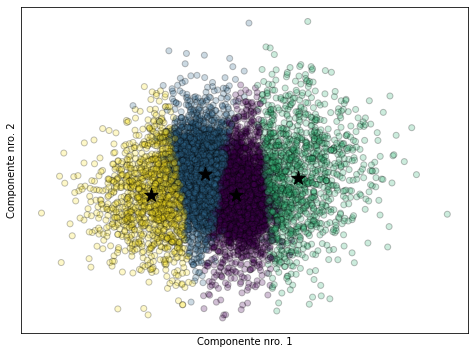

In [59]:
graficar_PCA(model=kmean, raw_data=p_gfp.T, random_state=seed)

### TSNE

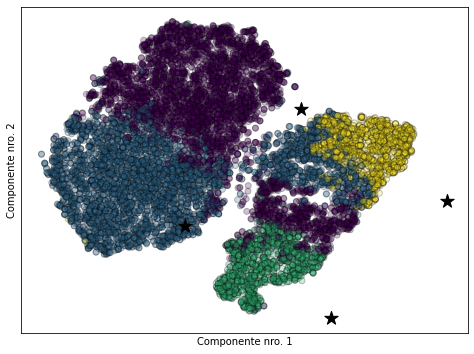

In [69]:
TSNE_Custom(model_data=p_gfp.T, model_centroids=kmean.cluster_centers_, model_labels=kmean.labels_, random_state=seed, plot='yes')

## KMeans Modificado

### PCA

[685.08947525 182.37821028]
[0.49117534 0.13075617]


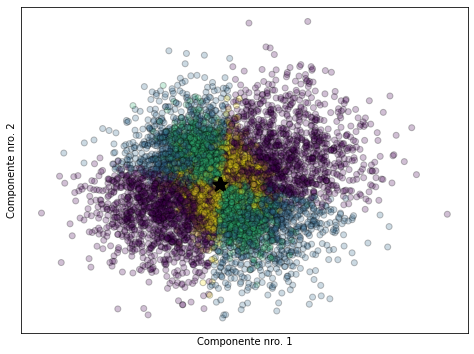

In [60]:
kmean_modif_model = type('object', (object,),{'labels_': labels_gfp, 'cluster_centers_': maps_kmeans})
graficar_PCA(model=kmean_modif_model, raw_data=p_gfp.T, random_state=seed)

### TSNE

In [98]:
TSNE_Custom(model_data=p_gfp.T, model_centroids=maps_kmeans, model_labels=labels_gfp, random_state=seed, plot='yes')